In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
import math
sys.path.append('../..')
from lib.data_encoding import german_credit_encoding

In [2]:
class DetectorEnsemble:
    def __init__(self):
        self.detectors = []
        
        #self.detectors.append(('knn', NearestNeighbors(algorithm='ball_tree')))
        
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=10)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=15)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=20)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=25)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=30)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=35)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=40)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=45)))
        self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed", n_neighbors=50)))
        '''
        #self.detectors.append(('robustcov', MinCovDet()))
        #self.detectors.append(('iforest', IsolationForest()))
        #self.detectors.append(('ocsvm', OneClassSVM()))
        #self.detectors.append(('dbscan',  DBSCAN()))
        
        self.detectors.append(('iforest1', IsolationForest(random_state = 0, max_samples = 128, n_estimators = 100)))
        self.detectors.append(('iforest2', IsolationForest(random_state = 0, max_samples = 128, n_estimators = 200)))
        self.detectors.append(('iforest3', IsolationForest(random_state = 0, max_samples = 256, n_estimators = 100)))
        self.detectors.append(('iforest4', IsolationForest(random_state = 0, max_samples = 256, n_estimators = 200)))
        self.detectors.append(('iforest5', IsolationForest(random_state = 0, max_samples = 512, n_estimators = 100)))
        self.detectors.append(('iforest6', IsolationForest(random_state = 0, max_samples = 512, n_estimators = 200)))
        '''
        
    
    def fit_detector(self, X, y):
        self.clf = LinearRegression(fit_intercept=True, normalize=False, copy_X=True).fit(X, y)

    def fit(self, mat):
        dist = pairwise_distances(X = mat, metric='euclidean')
        self.scores = []
        for (name, detector) in self.detectors:
            if name[:3] == 'lof':
                detector.fit_predict(dist)
                self.scores.append(-detector.negative_outlier_factor_)
            elif name == 'robustcov':
                detector.fit(mat)
                self.scores.append(detector.mahalanobis(mat))
            elif name == 'knn':
                detector.fit(mat)
                self.scores.append(-detector.kneighbors(mat)[0][:, -1])
            elif name == 'dbscan':
                detector.fit(mat)
                score = np.array([1 if x == -1 else 0 for x in detector.labels_])
                self.scores.append(score)
            else:
                detector.fit_predict(mat)
                self.scores.append(-detector.score_samples(mat))
            print(name, min(self.scores[-1]), max(self.scores[-1]), self.scores[-1].shape)
        tmp = []
        for score in self.scores:
            min_s = np.min(score)
            max_s = np.max(score)
            range_s = max(1e-4, max_s - min_s)
            # score = (score - min_s) / range_s
            tmp.append(score)
        self.n = mat.shape[0]
        self.scores = np.array(tmp)
        self.ground_truth = {}
        self.adjust_sample_weight = self.n // 100
        self.weights = np.ones(len(self.detectors))
        weights = self.weights / np.sum(self.weights)

        self.scores = self.scores.transpose()
        y = (self.scores * weights).sum(axis = 1)
        print('before fit', self.scores.shape, y.shape)
        self.fit_detector(self.scores, y)
        print('after fit')
    
    def weighted_score(self):
        y = self.clf.predict(self.scores)
        for i in self.ground_truth:
            y[i] = self.ground_truth[i]
        return y

    def adjust_weight(self, idx, score):
        self.ground_truth[idx] = score
        sample_weight = np.ones(self.n)
        for i in self.ground_truth:
            sample_weight[i] = self.adjust_sample_weight
        y = self.weighted_score()
        self.fit_detector(self.scores, y)


In [3]:
from model.german_rf import get_model
import sys
sys.path.append('../..')
from lib.tree_extractor import path_extractor
clf, (X_train, y_train, X_test, y_test, data_table), dataset, model, parameters = get_model()
paths = path_extractor(clf, 'random forest', (X_train, y_train))

target = 'credit_risk'
X = data_table.drop(target, axis=1).values
y = data_table[target].values
from lib.tree_extractor import assign_samples
assign_samples(paths, (X, y))

features = data_table.columns[1:]
new_feature = {}
feature_pos = {}
for index, feature in enumerate(features):
    if ' - ' in feature:
        name, p = feature.split(' - ')
        p = int(p)
        if name not in new_feature:
            new_feature[name] = []
        while p >= len(new_feature[name]):
            new_feature[name].append(-1)
        new_feature[name][p] = index
    else:
        new_feature[feature] = [index]

feature_range = {}
for key in new_feature:
    if key in data_table.columns:
        feature_range[key] = [data_table[key].min(), data_table[key].max() + 1]
    else:
        feature_range[key] = [0, len(new_feature[key])]
    for i, j in enumerate(new_feature[key]):
        feature_pos[j] = (key, i)

for index, path in enumerate(paths):
    path['index'] = index

paths = [path for path in paths if np.sum(path['sample']) > 0]


Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [6]:
mat = np.array([p['sample'] for p in paths]).astype('float')

for i, path in enumerate(paths):
    sum = np.sqrt(np.sum(mat[i]))
    if sum > 0:
        mat[i] /= sum

#ensemble = DetectorEnsemble()
#ensemble.fit(mat)
#selected_path_idxes = ensemble.weighted_score().argsort()[::-1]


In [5]:
output_labels = ['reject', 'accept']
current_encoding = german_credit_encoding

def interpret_path(path):
    conds = {}
    for k in path['range']:
        name = feature_pos[k][0]
        val = path['range'][k]
        if name in current_encoding:
            if name not in conds:
                conds[name] = [1] * len(current_encoding[name])
            if name in data_table.columns:
                for i in range(feature_range[name][0], feature_range[name][1]):
                    if i < val[0] or i > val[1]:
                        conds[name][i - feature_range[name][0]] = 0
            else:
                if val[0] > 0:
                    conds[name] = [0] * len(current_encoding[name])
                    conds[name][feature_pos[k][1]] = 1
                else:
                    conds[name][feature_pos[k][1]] = 0
        else:
            cond = [max(feature_range[name][0], val[0]), min(feature_range[name][1], val[1])]
            conds[name] = cond

    output_conds = []
    for name in conds:
        val = conds[name]
        op = 'is'
        value = ''
        if name in current_encoding:
            is_negation = np.sum(val) * 2 >= len(val) and len(val) > 2
            if is_negation:
                op = 'is not'
                for i, d in enumerate(val):
                    if d == 0:
                        value = value + ' and ' + current_encoding[name][i]
                value = value[5:]
            else:
                for i, d in enumerate(val):
                    if d == 1:
                        value = value + ' or ' + current_encoding[name][i]
                value = value[4:]
        else:
            if val[0] == feature_range[name][0]:
                op = '<='
                value = int(val[1])
            elif val[1] == feature_range[name][1]:
                op = '>='
                value = int(val[0])
            else:
                op = 'in'
                value = '%d to %d' % (int(val[0]), int(val[1]))
        output_conds.append((name, op, value))
    output_label = output_labels[path['output']]
    # print(output_labels, path['output'])
    # print(conds)
    return output_conds, output_label

In [25]:
interpret_path(paths[4073])

([('credit_history', 'is not', 'all credits at this bank paid back duly'),
  ('housing', 'is', 'own'),
  ('employment_duration', 'is not', 'unemployed and < 1 yr'),
  ('other_debtors', 'is not', 'guarantor'),
  ('duration', '>=', 10),
  ('status', 'is not', '... >= 200 DM (salary)'),
  ('age', '<=', 35),
  ('installment_rate', 'is', '< 20')],
 'accept')

In [53]:
all_score = {}
for i in range(ensemble.scores.shape[1]):
    all_score[i] = ensemble.scores[:, i]
df = pd.DataFrame(all_score)
df.corr()

,0,1,2,3,4,5,6,7,8
0,1.000000,0.924329,0.857334,0.803923,0.755778,0.715738,0.680796,0.650421,0.621668
1,0.924329,1.000000,0.964276,0.922553,0.880706,0.842078,0.807477,0.775130,0.744436
2,0.857334,0.964276,1.000000,0.976921,0.946278,0.914515,0.884306,0.854563,0.825672
3,0.803923,0.922553,0.976921,1.000000,0.983731,0.962043,0.938536,0.913338,0.887984
4,0.755778,0.880706,0.946278,0.983731,1.000000,0.988634,0.972787,0.953547,0.932867
5,0.715738,0.842078,0.914515,0.962043,0.988634,1.000000,0.991597,0.978789,0.962987
6,0.680796,0.807477,0.884306,0.938536,0.972787,0.991597,1.000000,0.993436,0.982923
7,0.650421,0.775130,0.854563,0.913338,0.953547,0.978789,0.993436,1.000000,0.994604
8,0.621668,0.744436,0.825672,0.887984,0.932867,0.962987,0.982923,0.994604,1.000000


In [54]:
all_top = []
for i in range(ensemble.scores.shape[1]):
    all_top += ensemble.scores[:, i].argsort()[::-1][:50].tolist()
all_top = list(set(all_top))
print(len(all_top))

115


In [8]:
dist = pairwise_distances(X = mat, metric='cosine')

class MyLOF:
    def __init__(self, dist, k):
        self.dist = dist
        self.k = k
        self.neighbors = [dist[i].argsort()[:1000 + 1] for i in range(dist.shape[0])]
        #self.k_dist = [dist[i, self.neighbors[i][k]] for i in range(dist.shape[0])]

    def reach_dist(self, i, j, k):
        return max(self.dist[j, self.neighbors[j][k]], self.dist[i, j])

    def k_dist(self, i, k):
        return dist[i, self.neighbors[i][k]]

    def lrd(self, i, k):
        dist_sum = 0
        for j in self.neighbors[i][1 : 1+k]:
            dist_sum += self.reach_dist(i, j, k)
        return k / dist_sum

    def detailed_lof(self, i):
        lrd_sum = 0
        for j in self.neighbors[i][1:]:
            val = self.lrd(j)
            print(j, val)
            lrd_sum += val
        val = self.lrd(i)
        print(i, val, self.k_dist[i])
        print(lrd_sum / self.k)
        return lrd_sum / (val * self.k)

    def lof(self, i, k = 0):
        if k == 0:
            k = self.k
        lrd_sum = 0
        for j in self.neighbors[i][1 : 1+k]:
            val = self.lrd(j, k)
            lrd_sum += val
        val = self.lrd(i, k)
        return lrd_sum / (val * k)

my = MyLOF(dist, 10)

In [11]:
[i for i in my.neighbors[2280] if i in my.neighbors[2807]]

[6884, 9096, 8073, 2398, 8911]

In [51]:
interpret_path(paths[6641])

([('status', 'is not', '... >= 200 DM (salary)'),
  ('present_residence', 'is not', '< 1 yr'),
  ('duration', '>=', 10),
  ('purpose', 'is not', 'car (new)'),
  ('property', 'is', 'building soc. savings agr./life insurance'),
  ('other_debtors', 'is', 'guarantor')],
 'accept')

In [33]:
for i in vec:
    print(interpret_path(paths[i]))

([('status', 'is not', '... >= 200 DM (salary)'), ('other_debtors', 'is not', 'none'), ('age', '>=', 43)], 'accept')
([('other_installment_plans', 'is not', 'bank'), ('credit_history', 'is not', 'delay in paying off in the past'), ('other_debtors', 'is', 'guarantor'), ('age', '>=', 36)], 'accept')
([('status', 'is not', '... >= 200 DM (salary)'), ('savings', 'is not', '500 to 1000 DM and >= 1000 DM'), ('other_debtors', 'is', 'guarantor'), ('age', '>=', 31)], 'accept')
([('credit_history', 'is not', 'all credits at this bank paid back duly'), ('status', 'is not', '... >= 200 DM (salary)'), ('other_debtors', 'is', 'guarantor'), ('age', '>=', 31)], 'accept')
([('status', 'is not', '... >= 200 DM (salary)'), ('other_debtors', 'is', 'guarantor'), ('present_residence', 'is', '>= 7 yrs')], 'accept')


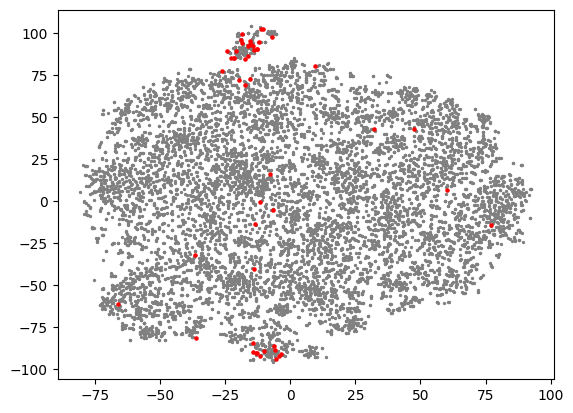

In [53]:
vec = [6028,  468, 7305, 4812, 3204, 4086,   69, 3400, 6569, 2279, 7529,
       2089, 2706, 7527, 1884, 6290, 4657, 2363,  585, 1507, 5818, 4650,
       6788, 1750, 4466,  405, 4932, 1840,  868, 4350, 3098, 4459, 4234,
       4479, 5961, 4161, 1251, 6497, 1703, 8624, 2807, 6641, 6692, 1761,
       9283, 4296, 6607, 6141, 3731, 3795]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[vec, 0], x_tsne[vec, 1], s = 5, color='red')
plt.show()

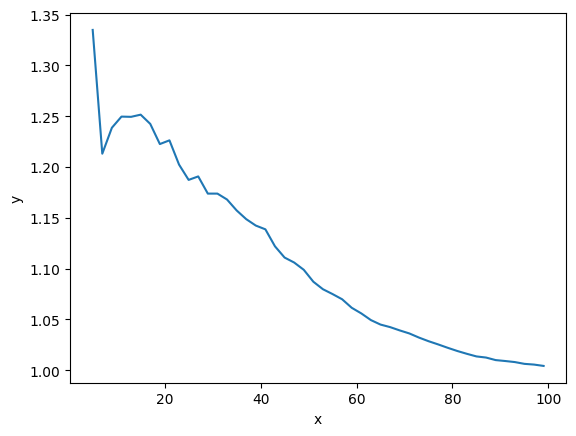

In [35]:
linedata = pd.DataFrame({
    'y': [my.lof(2089, k) for k in range(5, 100, 2)],
    'x': [k for k in range(5, 100, 2)],
}, columns=['x', 'y'])
sns.lineplot(x="x",
             y="y",
             data=linedata)

plt.show()


In [46]:
my.lof(3486)

7098 0.8534440968386461
3363 0.8593449266617732
8364 0.8707929829982152
5513 0.844024524701299
4479 0.8524918116575216
6489 0.8391957373813956
3842 0.8213554197708771
3881 0.9046825101401719
2349 0.8910114106315323
5707 0.8506974082626138
2614 0.886344462983439
6378 0.9344059650865604
7557 0.8525030376026921
9345 0.8228965765464948
2882 0.8191080686716692
9110 0.8462938078919369
6208 0.8598734281662452
5722 0.9034571622788968
6749 0.894284700149145
8199 0.8662394798808549
3486 0.7971004158638638 1.273885093688925
0.863622375915099


1.0834549308058528

In [54]:
my.lof(4466)

2750 1.0150831017114255
2124 1.032807514176293
1010 0.8771370795301957
8258 0.8741062787339936
9010 0.9867392621614066
382 0.9148370154352409
6980 1.031206729504436
6607 0.9030821523035811
1071 1.0389343254040504
3163 0.9296036991299087
4515 0.8622053360116771
6140 1.025713418548773
8843 1.0100970832656126
4082 1.01376850233137
3568 0.8573544478336619
9323 0.8842620682112152
3701 0.9845147465719187
4785 0.8305766242808341
680 1.03749523271083
5116 1.029726998112385
4466 0.8690287309571502 1.1751661752321785
0.9569625807984403


1.1011863551903969

In [52]:
rules = []
class_count = {}
max_n_conds = 0
top_n = 50
filtered_id = {}
all_labels = {}
count = 0
labels = '1011011001111011000011100111110101111101011000111111111111101110010111011111010101101111110011101011111011011001100'
for attr_id in range(len(ensemble.detectors)):
    idxes = ensemble.scores[:, attr_id].argsort()[::-1][:top_n]
    anomalies = 0
    print('attr', attr_id)
    for it, i in enumerate(idxes):
        conds, output = interpret_path(paths[i])
        class_count[output] = class_count.get(output, 0) + 1
        if labels[filtered_id.get(i, count)] == '1':
            anomalies += 1
        j = it + 1
        if j == 10 or j == 20 or j == 50:
            print('precision@%d: %.2f' % (j, anomalies / j))
        if i in filtered_id:
            continue
        all_labels[i] = labels[filtered_id.get(i, count)]
        filtered_id[i] = count
        count += 1
        rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': attr_id })
        max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

attr 0
precision@10: 0.60
precision@20: 0.55
precision@50: 0.64
attr 1
precision@10: 0.70
precision@20: 0.65
precision@50: 0.72
attr 2
precision@10: 0.70
precision@20: 0.65
precision@50: 0.76
attr 3
precision@10: 0.80
precision@20: 0.75
precision@50: 0.74
attr 4
precision@10: 0.80
precision@20: 0.75
precision@50: 0.78
attr 5
precision@10: 0.90
precision@20: 0.75
precision@50: 0.76
attr 6
precision@10: 0.80
precision@20: 0.80
precision@50: 0.74
attr 7
precision@10: 0.70
precision@20: 0.75
precision@50: 0.76
attr 8
precision@10: 0.70
precision@20: 0.70
precision@50: 0.70


In [26]:
all_labels = {7305: '1', 8624: '0', 1884: '1', 468: '1', 6290: '0', 8055: '1', 2280: '1', 3400: '0', 4466: '0', 4650: '1', 6028: '1', 4459: '1', 1411: '1', 665: '0', 868: '1', 8911: '1', 3848: '0', 9283: '0', 5218: '0', 3035: '0', 1010: '1', 8934: '1', 6483: '1', 2807: '0', 5767: '0', 1763: '1', 4479: '1', 679: '1', 873: '1', 6641: '1', 178: '0', 2278: '1', 7567: '0', 287: '1', 7527: '1', 6569: '1', 3487: '1', 2363: '1', 1750: '0', 2300: '1', 6277: '0', 8240: '1', 7499: '1', 525: '0', 4785: '0', 9324: '0', 3337: '1', 3617: '1', 5003: '1', 2089: '1', 3204: '1', 991: '1', 2167: '1', 3488: '1', 1507: '1', 1840: '1', 4932: '1', 254: '1', 9096: '1', 5974: '0', 7529: '1', 2764: '1', 9134: '1', 2112: '0', 7845: '0', 8073: '1', 4657: '0', 3270: '1', 5502: '1', 616: '1', 6787: '0', 6801: '1', 3486: '1', 405: '1', 3485: '1', 8092: '1', 1393: '0', 668: '1', 8389: '0', 2277: '1', 8629: '0', 1520: '1', 4104: '1', 712: '0', 6952: '1', 1330: '1', 8415: '1', 6471: '1', 690: '1', 5575: '1', 5590: '0', 5252: '0', 2079: '1', 1940: '1', 3891: '1', 2916: '0', 1939: '1', 6839: '0', 4384: '1', 3628: '1', 2664: '1', 8645: '1', 7572: '1', 736: '0', 2228: '1', 4759: '1', 729: '0', 4980: '1', 2009: '1', 2099: '0', 4995: '0', 7810: '1', 7571: '1', 5459: '0', 2817: '0'}


In [56]:
len(all_labels)

0

In [55]:
rules = []
class_count = {}
all_labels = {}
max_n_conds = 0
top_n = 200
filtered_id = {}
count = 0
for attr_id in range(4, 5):
    idxes = vec
    print('attr', attr_id)
    anomalies = 0
    for it, i in enumerate(idxes):
        conds, output = interpret_path(paths[i])
        class_count[output] = class_count.get(output, 0) + 1
        if i in all_labels:
            if all_labels[i] == '1':
                anomalies += 1
            j = it + 1
            if j == 10 or j == 20 or j == 50:
                print('precision@%d: %.2f' % (j, anomalies / j))
        label = all_labels.get(i, -1)
        count += 1
        rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': attr_id, 'labels': int(label) })
        max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

attr 4


In [23]:
ensemble.scores[6290, 3]

0.650736751792914

In [25]:
print(my.lof(6290), ensemble.scores[6290, 3])

1.108120030705061 0.650736751792914


1.108120030705061


In [51]:
for i in dist[6290].argsort()[:20]:
    print(rank[i])

323
9614
9504
9587
9558
9586
2794
6173
9593
9237
9461
9497
9569
9567
9579
9155
9453
111
9639
9085


In [50]:
idxes = ensemble.scores[:, 5].argsort()[::-1]
rank = {}
for i, j in enumerate(idxes):
    rank[j] = i

In [56]:
f = open('anomaly_loci.csv', 'w')

for it, rule in enumerate(rules):
    s = '' + str(rule['order'])
    line = 0
    n_conds = len(rule['cond'])
    n_lines = math.ceil(n_conds / conds_per_line)
    index = rule['index']

    for line in range(n_lines):
        if line == 0:
            s += ',#%d,IF,' % (index)
        else:
            s += ',,,'
        for pos in range(conds_per_line):
            i = pos + line * conds_per_line
            if i < n_conds:
                item = rule['cond'][i]
                s += item[0] + ',' + item[1] + ',' + str(item[2]) + ','
                s += 'AND,' if i < n_conds - 1 else '...,'
            else:
                s += '...,...,...,...,'
        if line == n_lines - 1:
            s = s[:-4]
            s += 'THEN,%s,%d,%3f' % (rule['predict'], np.sum(paths[index]['distribution']), paths[index]['confidence'])
        s += '\n'
    f.write(s + '\n')
f.close()

In [55]:
print(len(rules))

115


In [31]:

new_index = {}
for index, path in enumerate(paths):
    new_index[path['index']] = index
marked = [7822, 5685, 2989, 3470, 5141, 5058, 9813, 1376, 3969, 7524, 7058, 3739, 3831, 453, 1107, 4529, 5776, 1338, 9709, 7921, 4958, 5032, 7417, 892, 6972, 3958, 2407, 932, 4101, 902, 3971, 146, 9544, 7381, 5875, 7165, 2853, 2107, 3855, 7712, 1061, 8968, 4245, 2805, 3347, 7748, 4970, 3786, 95, 3556, 5186, 8471, 8788, 6398, 6135, 4500, 9234, 3778, 3375, 8058, 9199, 2205, 1559, 7972, 2760, 250, 223, 9578, 303, 9804, 5608, 6384, 503, 4196, 4932, 7705, 6157, 2803, 5148, 8277, 190, 9431, 3477, 9156, 8893, 8457, 4930, 9061, 8279, 3453, 6226, 8381, 5124, 5786, 9902, 1208, 4456, 9906, 5527, 565, 9926, 2761, 2154, 582, 6133, 8975, 1564, 5967, 3906, 3694, 6819, 4557, 9653, 4017, 8027, 3487, 4172, 5947, 2529, 1934, 286, 9794, 2996, 2614, 7214, 1152, 5614, 5375, 5911, 2793, 9828, 4266, 2024, 3149, 8707, 3358]
marked = [new_index[i] for i in marked]
mark_label = [1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
labeled_anomaly = [j for i, j in enumerate(marked) if mark_label[i] == 1]
labeled_non_anomaly = [j for i, j in enumerate(marked) if mark_label[i] == 0]
print(labeled_anomaly)

[7528, 2879, 4946, 4868, 1325, 3832, 3608, 4358, 856, 2320, 7423, 4093, 4782, 3430, 6153, 3646, 3254, 8847, 215, 9208, 9422, 7416, 5921, 2702, 4952, 9067, 8138, 8715, 9519, 542, 9538, 2661, 8633, 5737, 3770, 6564, 3876, 1858, 5166]


In [34]:
new_index = {}
for index, path in enumerate(paths):
    new_index[path['index']] = index
marked = ensemble.scores[:, 2].argsort()[::-1][:50]
#marked = [new_index[i] for i in marked]
labeled_anomaly = [i for i in marked if all_labels[i] == '1']
labeled_non_anomaly = [i for i in marked if all_labels[i] == '0']
print(labeled_anomaly)

[2280, 8055, 6569, 6028, 4459, 1884, 4932, 7529, 7305, 3204, 2363, 2089, 8911, 4650, 868, 1507, 6641, 1763, 468, 8073, 3488, 679, 873, 2764, 3270, 2278, 5003, 2167, 991, 6483, 5502, 616, 1010, 1840, 6801, 3486, 405, 3485]


In [7]:
dist = pairwise_distances(X = mat, metric='euclidean')

In [19]:
from sklearn.manifold import TSNE
x_tsne = TSNE(n_components=2, metric='precomputed').fit_transform(dist)

NameError: name 'dist' is not defined

In [26]:
x_tsne = np.load('path_tsne.npy')

(9661, 9661)

In [38]:
score = ensemble.scores[:, 2]


NameError: name 'score' is not defined

In [48]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
#plt.scatter(x_tsne[labeled_non_anomaly, 0], x_tsne[labeled_non_anomaly, 1], s = 10, color='blue')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

NameError: name 'anomaly' is not defined

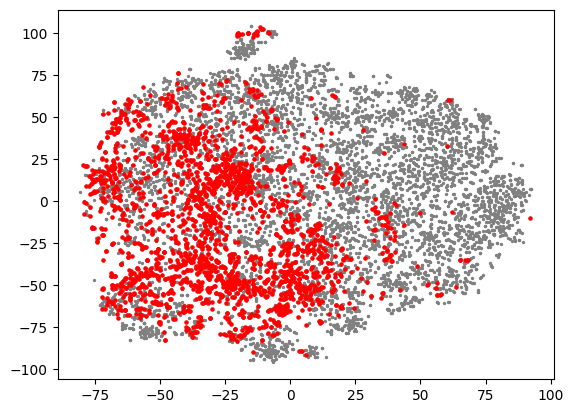

In [35]:
rejects = [i for i, p in enumerate(paths) if p['output'] == 0]
accepts = [i for i, p in enumerate(paths) if p['output'] == 1]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
#plt.scatter(x_tsne[labeled_non_anomaly, 0], x_tsne[labeled_non_anomaly, 1], s = 10, color='blue')
plt.scatter(x_tsne[rejects, 0], x_tsne[rejects, 1], s = 5, color='red')
plt.show()

In [51]:
strange

[6290, 665, 4466, 2112, 5218]

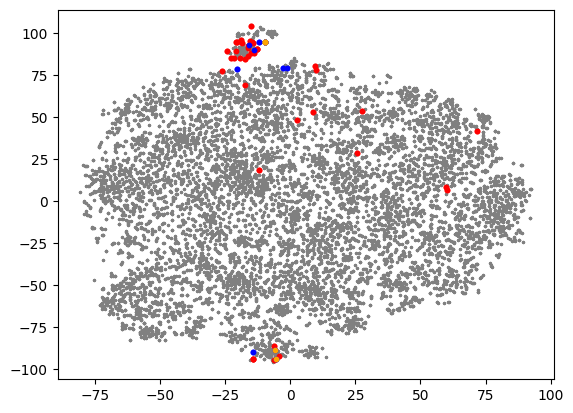

In [50]:
anomaly = ensemble.scores[:, 2].argsort()[::-1][:50]
high_status = [p for p in anomaly if 4 in paths[p]['range'] and paths[p]['range'][4][0] > 3]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[labeled_anomaly, 0], x_tsne[labeled_anomaly, 1], s = 10, color='red')
plt.scatter(x_tsne[labeled_non_anomaly, 0], x_tsne[labeled_non_anomaly, 1], s = 10, color='blue')
strange = [i for i in labeled_non_anomaly if 0 in paths[i]['range'] and paths[i]['range'][0][0] > 2]
plt.scatter(x_tsne[strange, 0], x_tsne[strange, 1], s = 10, color='orange')
plt.show()

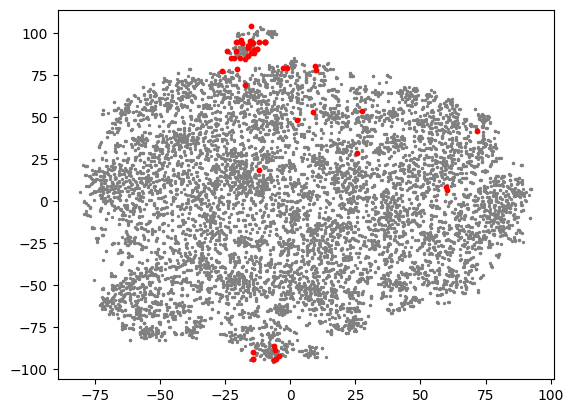

In [39]:
anomaly = ensemble.scores[:, 0].argsort()[::-1][:50]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

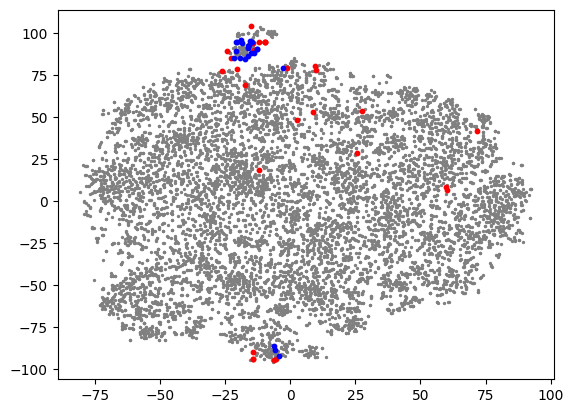

In [58]:
new_index = {}
for index, path in enumerate(paths):
    new_index[path['index']] = index
marked = ensemble.scores[:, 2].argsort()[::-1][:50]
#marked = [new_index[i] for i in marked]
low_density = [i for i in marked if my.lrd(i) < 0.9]
high_density = [i for i in marked if my.lrd(i) > 0.9]

anomaly = ensemble.scores[:, 0].argsort()[::-1][:50]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[low_density, 0], x_tsne[low_density, 1], s = 10, color='red')
plt.scatter(x_tsne[high_density, 0], x_tsne[high_density, 1], s = 10, color='blue')
plt.show()


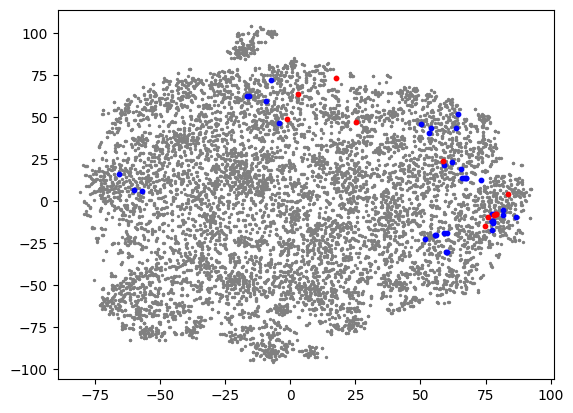

In [27]:
#anomaly = ensemble.scores[:, 0].argsort()[::-1][:50]
#marked = [j for i, j in enumerate(anomaly) if '10111010101011011011100111110011111110011111101111'[i] == '1']
marked = [j for i, j in enumerate(anomaly) if '110000010000010000000000010010110000010000010010000'[i] == '1']
marked2 = [j for i, j in enumerate(anomaly) if '110000010000010000000000010010110000010000010010000'[i] == '0']
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[marked2, 0], x_tsne[marked2, 1], s = 10, color='blue')
plt.scatter(x_tsne[marked, 0], x_tsne[marked, 1], s = 10, color='red')
plt.show()

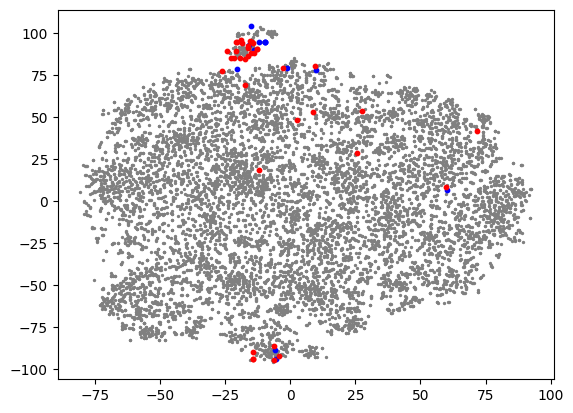

In [36]:

plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[labeled_non_anomaly, 0], x_tsne[labeled_non_anomaly, 1], s = 10, color='blue')
plt.scatter(x_tsne[labeled_anomaly, 0], x_tsne[labeled_anomaly, 1], s = 10, color='red')
plt.show()

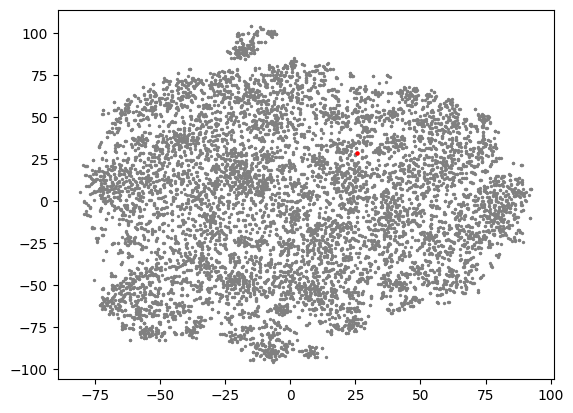

In [44]:
#debtors = [i for i, p in enumerate(paths) if 37 in p['range'] and p['range'][37][0] > 0]
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[[marked[-3]], 0], x_tsne[[marked[-3]], 1], s = 5, color='red')
plt.show()

In [24]:
print(feature_pos)

{0: ('status', 0), 1: ('duration', 0), 2: ('amount', 0), 3: ('savings', 0), 4: ('employment_duration', 0), 5: ('installment_rate', 0), 6: ('personal_status_sex', 0), 7: ('present_residence', 0), 8: ('age', 0), 9: ('credit_history', 0), 10: ('credit_history', 1), 11: ('credit_history', 2), 12: ('credit_history', 3), 13: ('credit_history', 4), 14: ('purpose', 0), 15: ('purpose', 1), 16: ('purpose', 2), 17: ('purpose', 3), 18: ('purpose', 4), 19: ('purpose', 5), 20: ('purpose', 6), -1: ('purpose', 7), 21: ('purpose', 8), 22: ('purpose', 9), 23: ('purpose', 10), 24: ('other_debtors', 0), 25: ('other_debtors', 1), 26: ('other_debtors', 2), 27: ('property', 0), 28: ('property', 1), 29: ('property', 2), 30: ('property', 3), 31: ('other_installment_plans', 0), 32: ('other_installment_plans', 1), 33: ('other_installment_plans', 2), 34: ('housing', 0), 35: ('housing', 1), 36: ('housing', 2), 37: ('job', 0), 38: ('job', 1), 39: ('job', 2), 40: ('job', 3), 41: ('people_liable', 0), 42: ('people_li

In [56]:
idxes = ensemble.scores[:, 2].argsort()[::-1][:50]
pos = []
neg = []
for i in idxes:
    if all_labels[i] == '0':
        print(i, my.lrd(i), all_labels[i])
        neg.append(my.lrd(i))
    else:
        pos.append(my.lrd(i))
print(np.mean(pos), np.mean(neg), pos)
print([i for i in idxes if all_labels[i] == '0'])

7567 0.8959076461510195 0
2807 0.8505640908040021 0
7845 0.8955450917788234 0
3400 0.8722663252755952 0
8624 0.8800285475381697 0
6290 0.9014124327269067 0
665 0.824315653967829 0
4466 0.8690287309571502 0
4657 0.9135537048167346 0
2112 0.8179461778194315 0
6787 0.9316291639123657 0
5218 0.830033610403313 0
0.8891280620653754 0.8735192646792784 [0.9031143309950695, 0.8605361874031598, 0.8437464947758613, 0.9172921724479135, 0.8340733126902512, 0.9666332098028634, 0.860093353101648, 0.8395992232523836, 0.9229402837194366, 0.939103850911939, 0.9512619788379685, 0.9157270315750887, 0.9502492175050682, 0.9046519214131378, 0.8198915773628763, 0.9415193754312108, 0.9063104387545443, 0.9590847449928888, 0.9901834489548015, 0.9831220250122797, 0.8103684944962438, 0.8900159898543631, 0.8900159898543631, 0.9814979203369956, 0.9149716728773883, 0.975599222494601, 0.8297412045739021, 0.8149630818096439, 0.858045409371504, 0.8184075229351049, 0.9174610379946893, 0.8135454593205923, 0.87713707953019

In [44]:
feature_pos

{0: ('status', 0),
 1: ('duration', 0),
 2: ('amount', 0),
 3: ('savings', 0),
 4: ('employment_duration', 0),
 5: ('installment_rate', 0),
 6: ('personal_status_sex', 0),
 7: ('present_residence', 0),
 8: ('age', 0),
 9: ('credit_history', 0),
 10: ('credit_history', 1),
 11: ('credit_history', 2),
 12: ('credit_history', 3),
 13: ('credit_history', 4),
 14: ('purpose', 0),
 15: ('purpose', 1),
 16: ('purpose', 2),
 17: ('purpose', 3),
 18: ('purpose', 4),
 19: ('purpose', 5),
 20: ('purpose', 6),
 -1: ('purpose', 7),
 21: ('purpose', 8),
 22: ('purpose', 9),
 23: ('purpose', 10),
 24: ('other_debtors', 0),
 25: ('other_debtors', 1),
 26: ('other_debtors', 2),
 27: ('property', 0),
 28: ('property', 1),
 29: ('property', 2),
 30: ('property', 3),
 31: ('other_installment_plans', 0),
 32: ('other_installment_plans', 1),
 33: ('other_installment_plans', 2),
 34: ('housing', 0),
 35: ('housing', 1),
 36: ('housing', 2),
 37: ('job', 0),
 38: ('job', 1),
 39: ('job', 2),
 40: ('job', 3),


In [45]:
intermarked[-3]

3486

In [41]:
'11111010101011011011110111110011111111011111101111'.count('1')

39

In [ ]:
for i in range()